In [2]:
import warnings
warnings.filterwarnings('ignore')

## Import Libraries

In [3]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

## Loading Data

In [4]:
df = pd.read_csv("alzheimers_disease_data.csv", index_col=0)

In [5]:
display(df.head())

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
PatientID,,,,,,,,,,,,,,,,,,,,,
4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,9.025679,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,7.151293,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,9.673574,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,5.597238,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid


In [6]:
# drop the column for doctor in charge
df = df.drop(df.columns[-1], axis=1)

In [7]:
df.shape
#edits

(2149, 33)

In [8]:
# Checking type of features
df.dtypes

Age                            int64
Gender                         int64
Ethnicity                      int64
EducationLevel                 int64
BMI                          float64
Smoking                        int64
AlcoholConsumption           float64
PhysicalActivity             float64
DietQuality                  float64
SleepQuality                 float64
FamilyHistoryAlzheimers        int64
CardiovascularDisease          int64
Diabetes                       int64
Depression                     int64
HeadInjury                     int64
Hypertension                   int64
SystolicBP                     int64
DiastolicBP                    int64
CholesterolTotal             float64
CholesterolLDL               float64
CholesterolHDL               float64
CholesterolTriglycerides     float64
MMSE                         float64
FunctionalAssessment         float64
MemoryComplaints               int64
BehavioralProblems             int64
ADL                          float64
C

In [9]:
# Check for null values
columns_with_null = df.columns[df.isnull().any()]
print("Columns with null values:", list(columns_with_null))

Columns with null values: []


In [10]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# import missingno as msno
# msno.matrix(df)
# plt.show()

# df.fillna(df.mean(), inplace=True)
# df.fillna(df.median(), inplace=True)  

Missing values in each column:
Age                          0
Gender                       0
Ethnicity                    0
EducationLevel               0
BMI                          0
Smoking                      0
AlcoholConsumption           0
PhysicalActivity             0
DietQuality                  0
SleepQuality                 0
FamilyHistoryAlzheimers      0
CardiovascularDisease        0
Diabetes                     0
Depression                   0
HeadInjury                   0
Hypertension                 0
SystolicBP                   0
DiastolicBP                  0
CholesterolTotal             0
CholesterolLDL               0
CholesterolHDL               0
CholesterolTriglycerides     0
MMSE                         0
FunctionalAssessment         0
MemoryComplaints             0
BehavioralProblems           0
ADL                          0
Confusion                    0
Disorientation               0
PersonalityChanges           0
DifficultyCompletingTasks    0
Forgetfu

### Heatmap

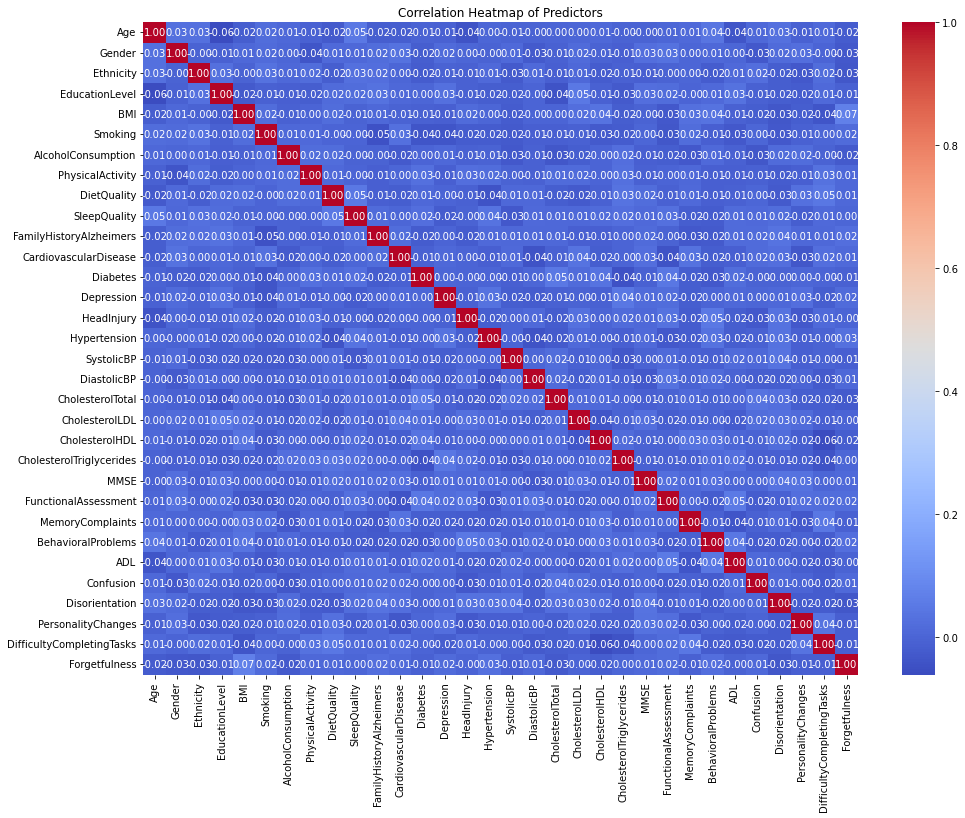

In [11]:
# Exclude target variable
predictors = df.drop(columns=['Diagnosis'])

# Compute correlation matrix
corr_matrix = predictors.corr()

# Plot heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Predictors")
plt.savefig("heatmap.jpg")
plt.show()


In [12]:
# Scaling numerical features
from sklearn.preprocessing import StandardScaler

# Identifying numeric columns
# numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns  # This incorrectly select all columns including categorical
numeric_columns = list(df.select_dtypes('float64').columns) + ['Age', 'SystolicBP', 'DiastolicBP']
scaler = StandardScaler()
scaled_df = df.copy()
scaled_df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

## Visualizing Correlations

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


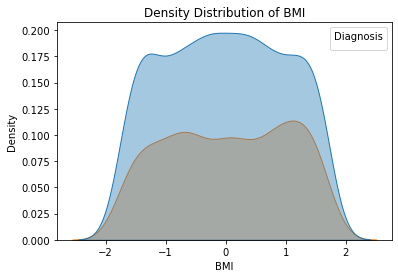

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


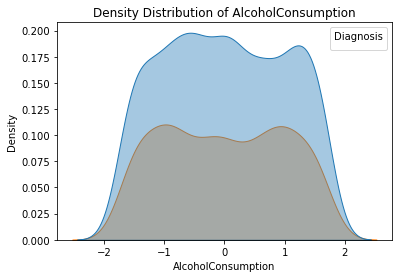

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


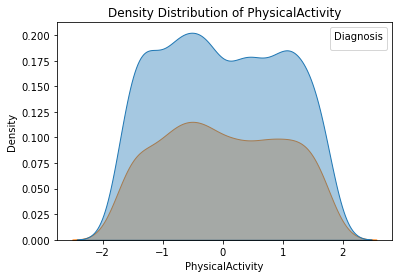

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


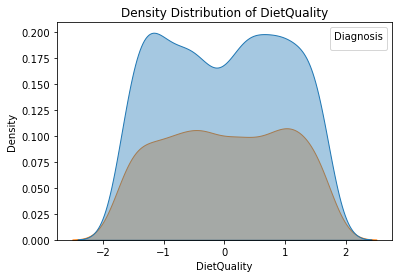

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


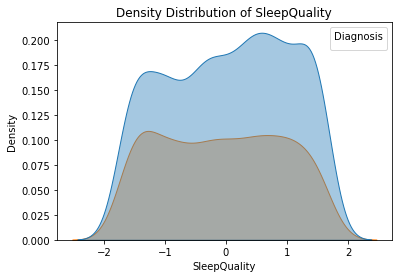

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


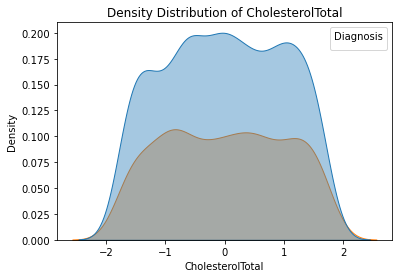

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


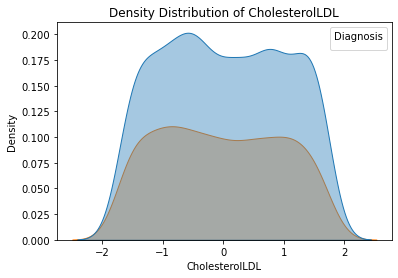

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


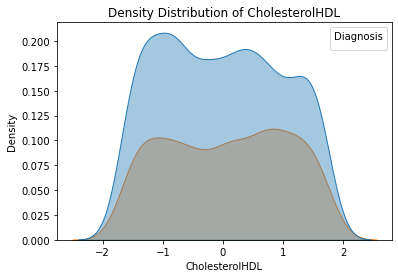

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


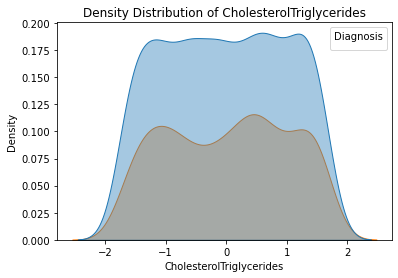

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


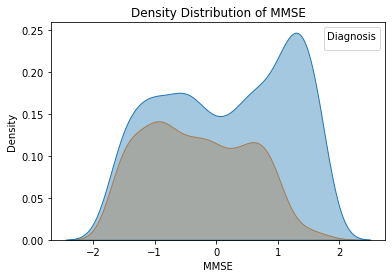

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


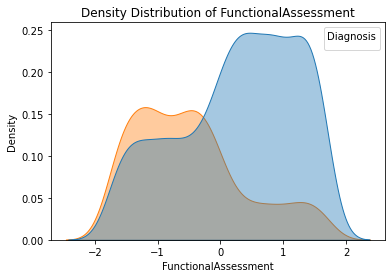

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


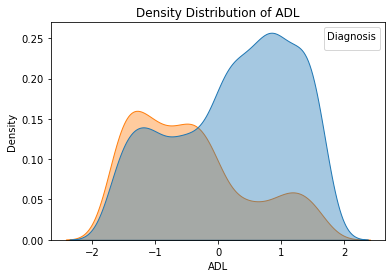

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


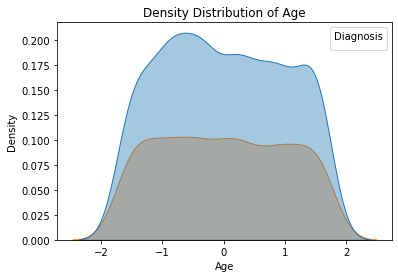

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


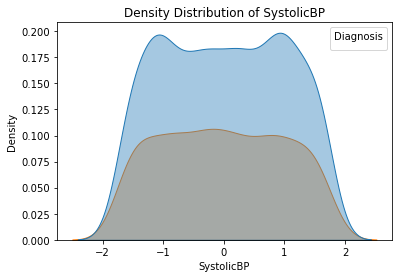

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


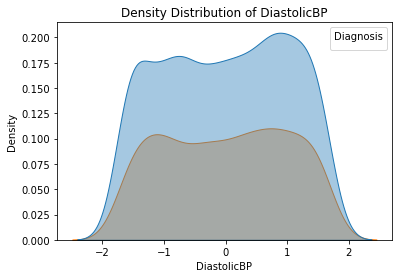

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# # List of variables for which to create density plots
# variables = ['Age', 'EducationLevel', 'FamilyHistoryAlzheimers', 'SleepQuality', 
#              'MMSE', 'FunctionalAssessment', 'ADL']

# Plot density distributions
for var in numeric_columns:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=scaled_df, x=var, hue='Diagnosis', fill=True, alpha=0.4)
    plt.title(f"Density Distribution of {var}")
    plt.xlabel(var)
    plt.ylabel("Density")
    plt.legend(title="Diagnosis")
    plt.show()


## TODO: T-test for some random/ multiple varibale pairs to see correlation, - Kirpa and visualize if necesarry - GT

In [14]:
X = scaled_df.drop(columns=['Diagnosis'])  # Predictors
y = scaled_df['Diagnosis']  # Target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the models
models = {
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler()),  # Scaling is important for LR
        ('model', LogisticRegression())
    ]),
    "Decision Tree": DecisionTreeClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Random Forest": RandomForestClassifier()
}

# Train and evaluate each model
results = {}
for model_name, pipeline in models.items():
    pipeline.fit(X_train, y_train)  # Train the model
    y_pred = pipeline.predict(X_test)  # Predict on test data
    accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
    results[model_name] = accuracy
    
    # Print classification report
    print(f"Model: {model_name}")
    print(classification_report(y_test, y_pred))
    print("-" * 50)

# Print overall results
print("Summary of Model Accuracies:")
for model, accuracy in results.items():
    print(f"{model}: {accuracy:.4f}")

Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       278
           1       0.74      0.74      0.74       152

    accuracy                           0.82       430
   macro avg       0.80      0.80      0.80       430
weighted avg       0.82      0.82      0.82       430

--------------------------------------------------
Model: Decision Tree
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       278
           1       0.82      0.85      0.83       152

    accuracy                           0.88       430
   macro avg       0.87      0.87      0.87       430
weighted avg       0.88      0.88      0.88       430

--------------------------------------------------
Model: XGBoost
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       278
           1       0.94      0.89      0.92       152

    accuracy     

In [15]:
# Check the coefficients of the logistic regression model

important_feat = sorted(zip(
    models['Logistic Regression'].named_steps['model'].coef_[0],
    X.columns
), key=lambda t: abs(t[0]), reverse=True)
important_feat[:7]

[(-1.3184664687436332, 'FunctionalAssessment'),
 (-1.270345751896021, 'ADL'),
 (1.1371611350810102, 'MemoryComplaints'),
 (0.9277537222604431, 'BehavioralProblems'),
 (-0.8595638533461293, 'MMSE'),
 (0.15008082728157718, 'CholesterolHDL'),
 (-0.1499734001091514, 'CholesterolLDL')]

In [16]:
# Check the feature importance of the decision tree model

important_feat = sorted(zip(
    models['Decision Tree'].feature_importances_,
    X.columns
), reverse=True)
important_feat[:7]

[(0.23938202986207263, 'MMSE'),
 (0.20346139012490574, 'ADL'),
 (0.18340490336847431, 'FunctionalAssessment'),
 (0.1427565882691379, 'MemoryComplaints'),
 (0.09892499202397032, 'BehavioralProblems'),
 (0.018161662554627277, 'DietQuality'),
 (0.016759750864033786, 'SystolicBP')]

We notice that the five Cognitive and Functional Assessment features contribute the most to our model, significantly surpassing all other features. This suggests that the final diagnosis may be directly derived from the results of these assessments.

## Applying Feature selection 
doing this after splitting to avoid data leakage

In [17]:
from sklearn.feature_selection import SelectKBest, f_classif

# Define predictors (X) and target (y)
X = scaled_df.drop(columns=['Diagnosis'])  # Predictors
y = scaled_df['Diagnosis']  # Target

# Feature Selection
# Select the top k features based on ANOVA F-value
k = 10  # Choose the number of features to retain (adjust based on experimentation)
selector = SelectKBest(score_func=f_classif, k=k)
X_selected = selector.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
print(f"Selected features: {selected_features}")

# Check and convert target to discrete classes if necessary
print("Before processing, unique values in y:", y.unique())

# Example: Binarize continuous target (adjust the threshold as needed)
threshold = 0.5  # Modify based on your problem domain
if y.dtypes in ['float64', 'float32']:  # Check if y is continuous
    y = (y > threshold).astype(int)

print("After processing, unique values in y:", y.unique())

# Proceed with feature selection and train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

# # Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

Selected features: Index(['EducationLevel', 'SleepQuality', 'FamilyHistoryAlzheimers',
       'Hypertension', 'CholesterolHDL', 'MMSE', 'FunctionalAssessment',
       'MemoryComplaints', 'BehavioralProblems', 'ADL'],
      dtype='object')
Before processing, unique values in y: [0 1]
After processing, unique values in y: [0 1]


In [18]:
# Define the models
models = {
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler()),  # Scaling is important for LR
        ('model', LogisticRegression())
    ]),
    "Decision Tree": DecisionTreeClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Random Forest": RandomForestClassifier()
}

# Train and evaluate each model
results = {}
for model_name, pipeline in models.items():
    pipeline.fit(X_train, y_train) 
    y_pred = pipeline.predict(X_test)  
    accuracy = accuracy_score(y_test, y_pred) 
    results[model_name] = accuracy
    
    # Print classification report
    print(f"Model: {model_name}")
    print(classification_report(y_test, y_pred))
    print("-" * 50)

print("Summary of Model Accuracies:")
for model, accuracy in results.items():
    print(f"{model}: {accuracy:.4f}")

Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       278
           1       0.75      0.75      0.75       152

    accuracy                           0.82       430
   macro avg       0.81      0.81      0.81       430
weighted avg       0.82      0.82      0.82       430

--------------------------------------------------
Model: Decision Tree
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       278
           1       0.87      0.89      0.88       152

    accuracy                           0.91       430
   macro avg       0.90      0.91      0.91       430
weighted avg       0.91      0.91      0.91       430

--------------------------------------------------
Model: XGBoost
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       278
           1       0.94      0.90      0.92       152

    accuracy     

# TODO: hyperparameter tuning - bingchengn and allie

After feature selection, the accuracy score for Random Forest is higher than XGBoost, unlike before feature selection.

>lr 0.844 (0.028)
>cart 0.906 (0.019)
>XGBoost 0.947 (0.013)
>rf 0.953 (0.012)
>stacking 0.951 (0.011)


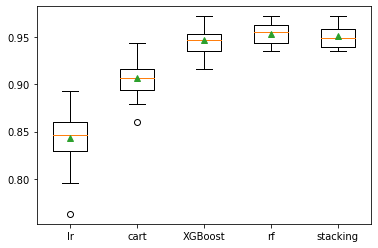

In [23]:
# compare ensemble to each baseline classifier
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from matplotlib import pyplot
from sklearn.feature_selection import SelectKBest, f_classif
 
# get the dataset
def get_dataset():
	X = scaled_df.drop(columns=['Diagnosis'])  # Predictors
	y = scaled_df['Diagnosis']  # Target
	k = 10
	selector = SelectKBest(score_func=f_classif, k=k)
	X_selected = selector.fit_transform(X, y)
	threshold = 0.5  # Modify based on your problem domain
	if y.dtypes in ['float64', 'float32']:  # Check if y is continuous
		y = (y > threshold).astype(int)
	return X_selected, y
 
# get a stacking ensemble of models
def get_stacking():
	# define the base models
	level0 = list()
	level0.append(('lr', LogisticRegression()))
	level0.append(('cart', DecisionTreeClassifier()))
	level0.append(('XGBoost', XGBClassifier(eval_metric='logloss')))
	level0.append(('rf', RandomForestClassifier()))
	# define meta learner model
	level1 = LogisticRegression()
	# define the stacking ensemble
	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
	return model

# get a list of models to evaluate
def get_models():
	stack_models = dict()
	stack_models['lr'] = LogisticRegression()
	stack_models['cart'] = DecisionTreeClassifier()
	stack_models['XGBoost'] = XGBClassifier(eval_metric='logloss')
	stack_models['rf'] = RandomForestClassifier()
	stack_models['stacking'] = get_stacking()
	return stack_models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores
 
# define dataset
X_selected, y = get_dataset()
# get the models to evaluate
stack_models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in stack_models.items():
	scores = evaluate_model(model, X_selected, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

rf performs almost the same as stacking

In [24]:
# Tunning hyperparameter 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from xgboost import XGBClassifier

# define dataset
X_selected, y = get_dataset()

# Tune hyperparameters for XGBoost
xgb = XGBClassifier(eval_metric='logloss')
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, cv=5,
                               scoring='accuracy', n_jobs=-1)
grid_search_xgb.fit(X_selected, y)

print("Best parameters for XGBoost:", grid_search_xgb.best_params_)
print("Best cross-validation accuracy for XGBoost:", grid_search_xgb.best_score_)


Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best cross-validation accuracy for XGBoost: 0.9524714045644277


In [25]:
# Tune hyperparameters for Random Forest
rf = RandomForestClassifier()
rf_param_grid = {
    'n_estimators': [150, 180, 200, 250],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [1, 2, 3, 5],
    'max_features': ['auto', 'sqrt']
}

grid_search_rf = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=5,
                              scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_selected, y)

print("Best parameters for Random Forest:", grid_search_rf.best_params_)
print("Best cross-validation accuracy for Random Forest:", grid_search_rf.best_score_)


Best parameters for Random Forest: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 3, 'n_estimators': 150}
Best cross-validation accuracy for Random Forest: 0.9529376050306283


In [26]:
# Tune hyperparameters for StackingClassifier
# Define base estimators
level0 = [
    ('lr', LogisticRegression()),
    ('cart', DecisionTreeClassifier()),
    ('XGBoost', XGBClassifier(eval_metric='logloss')),
    ('rf', RandomForestClassifier())
]
# Define meta learner
level1 = LogisticRegression()

stacking_clf = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)

# Define parameter grid
stacking_param_grid = {
    'final_estimator__C': [0.1, 1.0, 10.0],
    'XGBoost__n_estimators': [50, 100],
    'XGBoost__max_depth': [3, 5],
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [None, 5],
    'cart__max_depth': [None, 5, 10]
}

grid_search_stacking = GridSearchCV(estimator=stacking_clf, param_grid=stacking_param_grid, cv=5,
                                    scoring='accuracy', n_jobs=-1)
grid_search_stacking.fit(X_selected, y)

print("Best parameters for StackingClassifier:", grid_search_stacking.best_params_)
print("Best cross-validation accuracy for StackingClassifier:", grid_search_stacking.best_score_)

Best parameters for StackingClassifier: {'XGBoost__max_depth': 3, 'XGBoost__n_estimators': 100, 'cart__max_depth': None, 'final_estimator__C': 10.0, 'rf__max_depth': None, 'rf__n_estimators': 50}
Best cross-validation accuracy for StackingClassifier: 0.9520073724724887


Predictions based on Feature Categories

In [68]:
# Define feature categories
categories = {
    "Demographic": ['EducationLevel', 'FamilyHistoryAlzheimers'],
    "Lifestyle": ['SleepQuality', 'MemoryComplaints'],
    "Medical": ['Hypertension', 'CholesterolHDL', 'BehavioralProblems'],
    "Cognitive": ['MMSE', 'FunctionalAssessment', 'ADL']
}

# Iterate through each category, subset the data, and run the models
results_by_category = {}

for category, features in categories.items():
    print(f"\n### Predictions based on {category} features ###")
    
    # Subset the data
    X_category = scaled_df[features]
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_category, y, test_size=0.2, random_state=42, stratify=y)
    
    # Train and evaluate models
    results = {}
    for model_name, pipeline in models.items():
        pipeline.fit(X_train, y_train)  # Train the model
        y_pred = pipeline.predict(X_test)  # Predict on test data
        accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
        results[model_name] = accuracy

        # Print classification report
        print(f"Model: {model_name}")
        print(classification_report(y_test, y_pred))
        print("-" * 50)
    
    # Store results for this category
    results_by_category[category] = results

# Print overall results for each category
print("Summary of Model Accuracies by Feature Category:")
for category, result in results_by_category.items():
    print(f"\n{category}:")
    for model, accuracy in result.items():
        print(f"{model}: {accuracy:.4f}")


### Predictions based on Demographic features ###
Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.65      1.00      0.79       278
           1       0.00      0.00      0.00       152

    accuracy                           0.65       430
   macro avg       0.32      0.50      0.39       430
weighted avg       0.42      0.65      0.51       430

--------------------------------------------------
Model: Decision Tree
              precision    recall  f1-score   support

           0       0.65      1.00      0.79       278
           1       0.00      0.00      0.00       152

    accuracy                           0.65       430
   macro avg       0.32      0.50      0.39       430
weighted avg       0.42      0.65      0.51       430

--------------------------------------------------
Model: XGBoost
              precision    recall  f1-score   support

           0       0.65      1.00      0.79       278
           1       0.

# TODO: add remaining models for each category - allie

Visualize Model Accuracies

             Logistic Regression  Decision Tree   XGBoost  Random Forest
Demographic             0.646512       0.646512  0.646512       0.646512
Lifestyle               0.679070       0.593023  0.655814       0.593023
Medical                 0.693023       0.572093  0.644186       0.576744
Cognitive               0.795349       0.762791  0.809302       0.827907


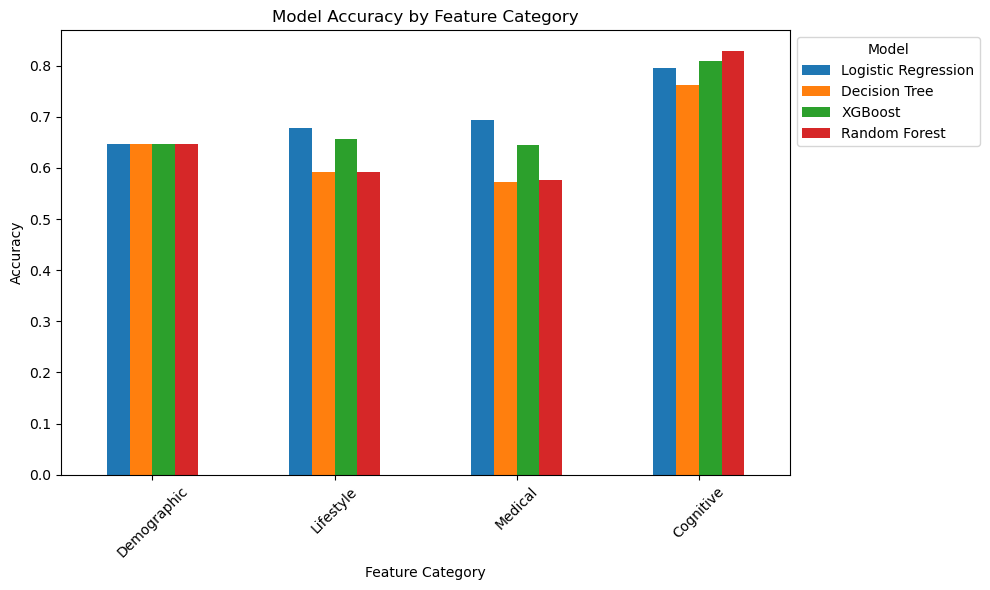

In [69]:
import pandas as pd

# converting results to a DataFrame for easy visualization
# .T - # Transpose for better readability
results_df = pd.DataFrame(results_by_category).T  
print(results_df)

# bar chart
results_df.plot(kind='bar', figsize=(10, 6))
plt.title("Model Accuracy by Feature Category")
plt.ylabel("Accuracy")
plt.xlabel("Feature Category")
plt.xticks(rotation=45)
plt.legend(title="Model", loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()  
plt.show()

MOVE the following visualization above modelling

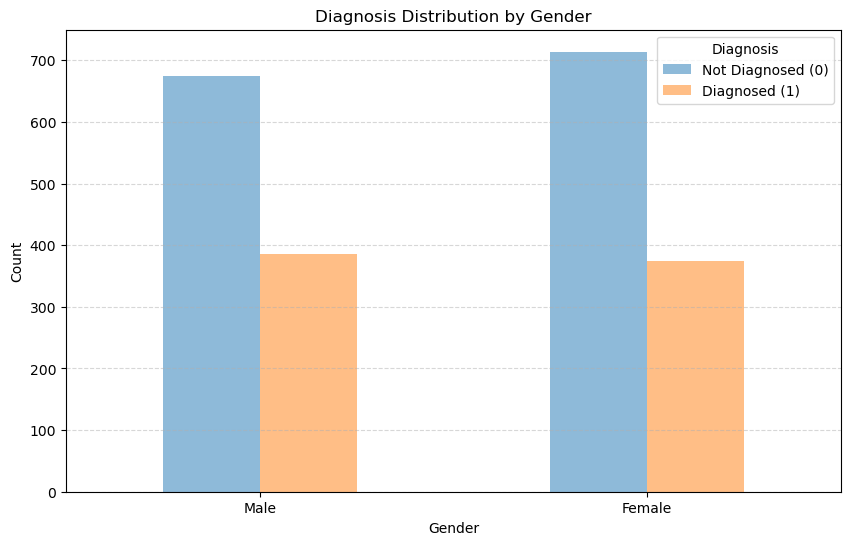

In [70]:
# Plot the count of diagnoses split by gender
gender_diagnosis_counts = df.groupby(['Gender', 'Diagnosis']).size().unstack(fill_value=0)
ax = gender_diagnosis_counts.plot(kind='bar', figsize=(10, 6), alpha=0.5)

plt.title('Diagnosis Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
ax.set_xticklabels(['Male', 'Female'])
plt.xticks(rotation=0)
plt.legend(title='Diagnosis', labels=['Not Diagnosed (0)', 'Diagnosed (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

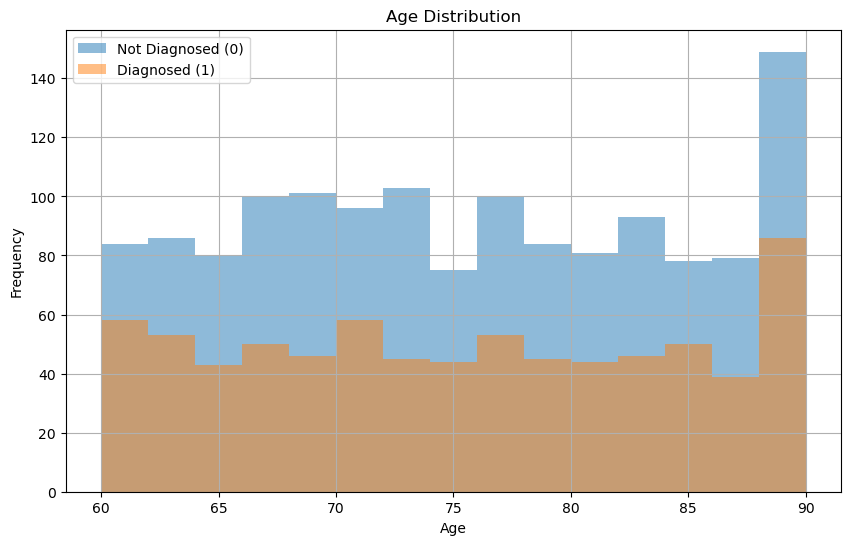

In [71]:
# Histograms for Age, split by Diagnosis
diagnosis_labels = {0: 'Not Diagnosed (0)', 1: 'Diagnosed (1)'}
plt.figure(figsize=(10, 6))
for diagnosis, group in df.groupby('Diagnosis'):
    plt.hist(group['Age'], bins=15, alpha=0.5, label=diagnosis_labels[diagnosis])

plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


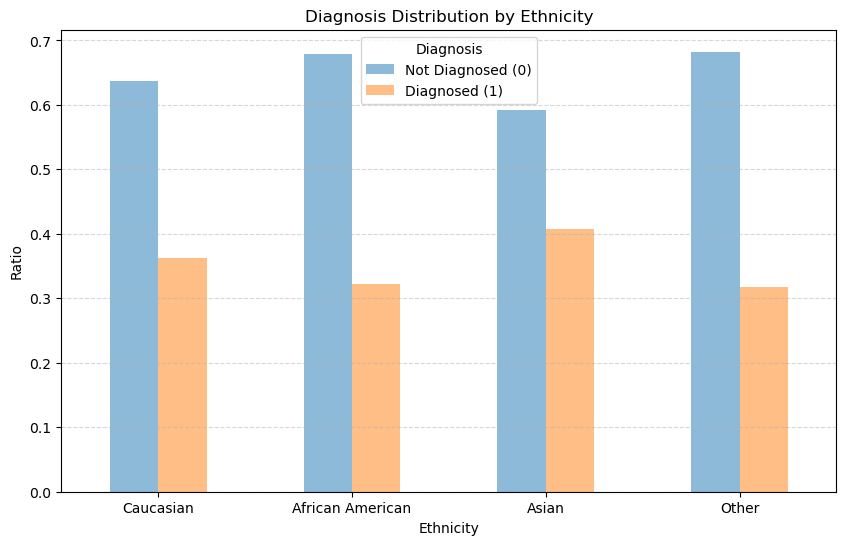

In [72]:
# Plot the ratio of diagnoses split by ethnicity
gender_diagnosis_counts = df.groupby(['Ethnicity', 'Diagnosis']).size().unstack(fill_value=0)
gender_diagnosis_ratio = gender_diagnosis_counts.divide(gender_diagnosis_counts.sum(axis=1), axis=0)
ax = gender_diagnosis_ratio.plot(kind='bar', figsize=(10, 6), alpha=0.5)

plt.title('Diagnosis Distribution by Ethnicity')
plt.xlabel('Ethnicity')
plt.ylabel('Ratio')
ax.set_xticklabels(['Caucasian', 'African American', 'Asian', 'Other'])
plt.xticks(rotation=0)
plt.legend(title='Diagnosis', labels=['Not Diagnosed (0)', 'Diagnosed (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

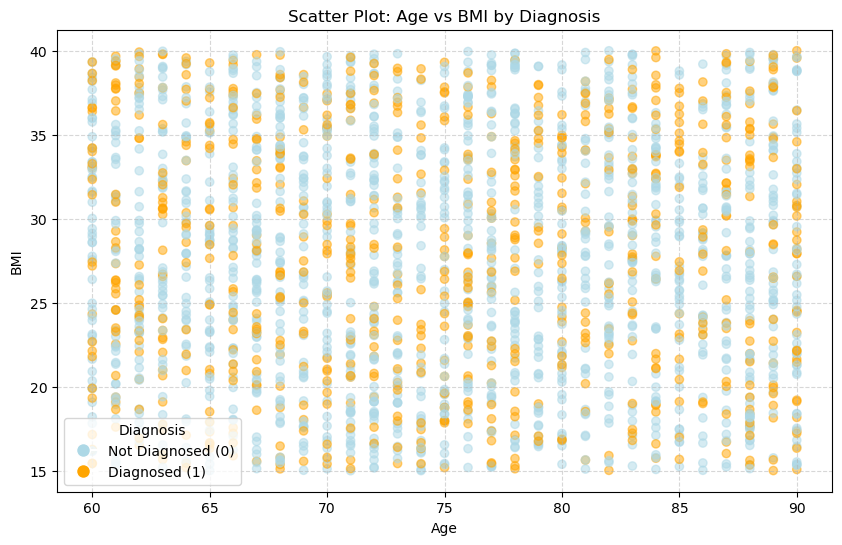

In [73]:
# Scatter plot for Age vs. BMI with Diagnosis as color
import matplotlib.lines as mlines

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df['Age'], 
    df['BMI'], 
    c=['lightblue' if diag == 0 else 'orange' for diag in df['Diagnosis']],
    alpha=0.5,
)

legend_labels = [mlines.Line2D([], [], marker='o', color='w', markerfacecolor='lightblue', markersize=10, label='Not Diagnosed (0)'),
                 mlines.Line2D([], [], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Diagnosed (1)')]
plt.legend(handles=legend_labels, title='Diagnosis')

# Adding color bar and labels
plt.title('Scatter Plot: Age vs BMI by Diagnosis')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

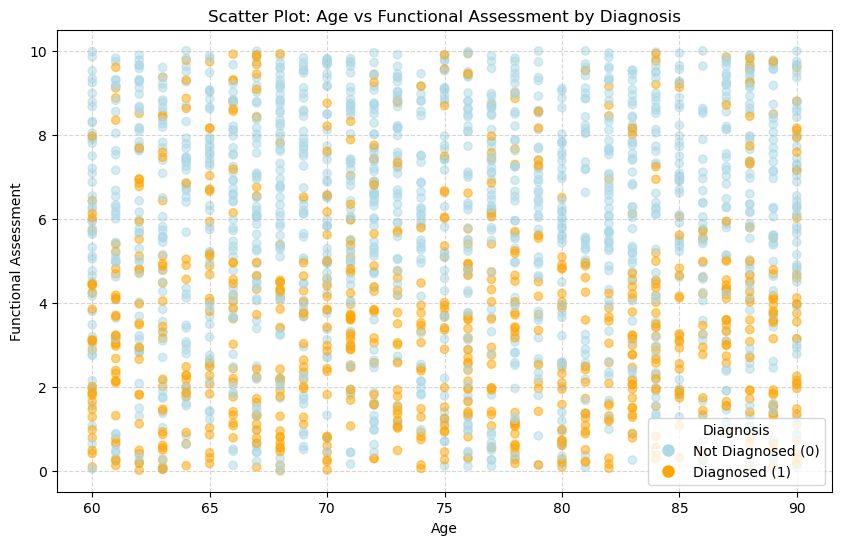

In [74]:
# Scatter plot for Age vs. Functional Assessment with Diagnosis as color
import matplotlib.lines as mlines

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df['Age'], 
    df['FunctionalAssessment'], 
    c=['lightblue' if diag == 0 else 'orange' for diag in df['Diagnosis']],
    alpha=0.5,
)

legend_labels = [mlines.Line2D([], [], marker='o', color='w', markerfacecolor='lightblue', markersize=10, label='Not Diagnosed (0)'),
                 mlines.Line2D([], [], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Diagnosed (1)')]
plt.legend(handles=legend_labels, title='Diagnosis')

# Adding color bar and labels
plt.title('Scatter Plot: Age vs Functional Assessment by Diagnosis')
plt.xlabel('Age')
plt.ylabel('Functional Assessment')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [76]:
# Check the coefficients of the logistic regression model
model
important_feat = sorted(zip(
    models['Logistic Regression'].named_steps['model'].coef_[0],
    X.columns
), key=lambda t: abs(t[0]), reverse=True)
important_feat[:7]



[(-0.9141530243688613, 'Gender'),
 (-0.8807369816215512, 'Ethnicity'),
 (-0.61775062779071, 'Age')]

In [77]:
# Check the feature importance of the decision tree model

important_feat = sorted(zip(
    models['Decision Tree'].feature_importances_,
    X.columns
), reverse=True)
important_feat[:7]

[(0.3546140743130112, 'Age'),
 (0.3230434958094986, 'Gender'),
 (0.3223424298774902, 'Ethnicity')]

In [78]:
# Here is a problem.
# We know the five most important variables now, but we cannot compare within them since the models don't agree to each other.
# Regardless of this, I chose to stick with logistic regression. Here are the results:
# For Male, Asian, and Other Ethnicity, Functional Assessment is recommended;
# For Female, Caucasian, and African American, ADL is recommended.
# Now you might guess Functional Assessment will be recommended for Asian Male, but indeed the most significant factor is MemoryComplaints.
# Yeah.

In [79]:
Group = scaled_df[(scaled_df['Gender']==0) & (scaled_df['Ethnicity']==2)]  # You can play around with this
X = Group.drop(columns=['Diagnosis'])  # Predictors
y = Group['Diagnosis']  # Target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the models
models = {
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler()),  # Scaling is important for LR
        ('model', LogisticRegression())
    ]),
    "Decision Tree": DecisionTreeClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Random Forest": RandomForestClassifier()
}

# Train and evaluate each model
results = {}
for model_name, pipeline in models.items():
    pipeline.fit(X_train, y_train)  # Train the model
    y_pred = pipeline.predict(X_test)  # Predict on test data
    accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
    results[model_name] = accuracy

# Check the coefficients of the logistic regression model

important_feat = sorted(zip(
    models['Logistic Regression'].named_steps['model'].coef_[0],
    X.columns
), key=lambda t: abs(t[0]), reverse=True)
important_feat[:7]

[(1.6012063246493469, 'MemoryComplaints'),
 (-1.3637339776224613, 'FunctionalAssessment'),
 (-0.7768694707206668, 'ADL'),
 (-0.7456878138806801, 'MMSE'),
 (-0.6935449700651926, 'Confusion'),
 (0.6396569076693545, 'DietQuality'),
 (0.6023347111549889, 'Disorientation')]

## Hypothesis Testing: Relationships Between Feature Groups

In [ ]:
from scipy.stats import ttest_ind, chi2_contingency

grouped_data = df.groupby('Ethnicity')

# Age comparison between diagnosed and non-diagnosed groups
diagnosed = grouped_data.get_group(1)['FunctionalAssessment']
not_diagnosed = grouped_data.get_group(0)['FunctionalAssessment']

t_stat, p_value = ttest_ind(diagnosed, not_diagnosed)
print(f"T-test for FunctionalAssessment: T-statistic={t_stat:.2f}, P-value={p_value:.4f}")

T-test for FunctionalAssessment: T-statistic=-0.57, P-value=0.5720


# check this t-test with other variable pairs